# Carregar dados para a memória

In [1]:
import pandas as pd
from pathlib import Path

# Path to the directory
directory_path = Path('./../../dados')

# Get all files in the directory
files = [f for f in directory_path.iterdir() if f.is_file()]

# df = pd.DataFrame()

# for file in files:
#     print(file.name)
#     aux_df = pd.read_csv(f"{directory_path}/{file.name}", sep=';')
#     df = pd.concat([df, aux_df])

df = pd.read_csv(f"{directory_path}/HIST_PAINEL_COVIDBR_2020_Parte1_18abr2025.csv", sep=";")

len(df)

714481

## Exemplo de outlier
No dia 2020-06-04 no Rio de Janeiro os casos foram registrados normalmente.

In [2]:
df.loc[418132]

regiao                            Sudeste
estado                                 RJ
municipio                  Rio de Janeiro
coduf                                  33
codmun                           330455.0
codRegiaoSaude                    33005.0
nomeRegiaoSaude           METROPOLITANA I
data                           2020-06-04
semanaEpi                              23
populacaoTCU2019                6718903.0
casosAcumulado                      33695
casosNovos                            744
obitosAcumulado                      4231
obitosNovos                           176
Recuperadosnovos                      NaN
emAcompanhamentoNovos                 NaN
interior/metropolitana                1.0
Name: 418132, dtype: object

Porém no dia 2020-06-05 tivemos um registro de 1.372.984 casos novos.

In [3]:
df.loc[418133]

regiao                            Sudeste
estado                                 RJ
municipio                  Rio de Janeiro
coduf                                  33
codmun                           330455.0
codRegiaoSaude                    33005.0
nomeRegiaoSaude           METROPOLITANA I
data                           2020-06-05
semanaEpi                              23
populacaoTCU2019                6718903.0
casosAcumulado                    1408687
casosNovos                        1374992
obitosAcumulado                     38643
obitosNovos                         34412
Recuperadosnovos                      NaN
emAcompanhamentoNovos                 NaN
interior/metropolitana                1.0
Name: 418133, dtype: object

E foi removido no dia 2020-06-06

In [4]:
df.loc[418134]

regiao                            Sudeste
estado                                 RJ
municipio                  Rio de Janeiro
coduf                                  33
codmun                           330455.0
codRegiaoSaude                    33005.0
nomeRegiaoSaude           METROPOLITANA I
data                           2020-06-06
semanaEpi                              23
populacaoTCU2019                6718903.0
casosAcumulado                      35703
casosNovos                       -1372984
obitosAcumulado                      4401
obitosNovos                        -34242
Recuperadosnovos                      NaN
emAcompanhamentoNovos                 NaN
interior/metropolitana                1.0
Name: 418134, dtype: object

# Remover dados faltantes

Removemos registros com municipio faltante pois ele pode prejudicar a contagem total de casos.

In [5]:
df = df[df['municipio'].notna()]
df = df.reset_index()
len(df)

707390

# Remover outliers

Os outliers nos _casosNovos_ impactam os _casosAcumulado_, então removeremos os outliers dos _casosNovos_ e recalcularemos os _casosAcumulado_.

## Tratando outliers

In [6]:
box_plot_df = pd.melt(df, id_vars=['index'], value_vars=['casosNovos', 'obitosNovos'])

In [7]:
df.columns

Index(['index', 'regiao', 'estado', 'municipio', 'coduf', 'codmun',
       'codRegiaoSaude', 'nomeRegiaoSaude', 'data', 'semanaEpi',
       'populacaoTCU2019', 'casosAcumulado', 'casosNovos', 'obitosAcumulado',
       'obitosNovos', 'Recuperadosnovos', 'emAcompanhamentoNovos',
       'interior/metropolitana'],
      dtype='object')

<Axes: xlabel='value', ylabel='variable'>

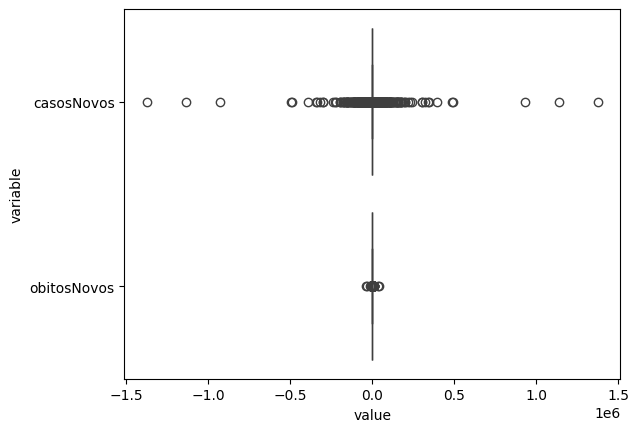

In [8]:
import seaborn as sns

sns.boxplot(data=box_plot_df, x="value", y="variable")

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df["z_score"] = scaler.fit_transform(df[['casosNovos']])

df["z_score"].describe()

count    7.073900e+05
mean     8.889443e-19
std      1.000001e+00
min     -3.164191e+02
25%     -8.643688e-04
50%     -8.643688e-04
75%     -6.339085e-04
max      3.168801e+02
Name: z_score, dtype: float64

Com isso definimos que um limite ideal para corte será de 3.

In [10]:
LIMITE_COMUM = 1

df_sem_outliers = df[abs(df["z_score"]) < LIMITE_COMUM]

print("Antes da remoção de outliers: ", len(df), "| Depois: ", len(df_sem_outliers))
print("Diferença: ", len(df) - len(df_sem_outliers))

Antes da remoção de outliers:  707390 | Depois:  704649
Diferença:  2741


<Axes: title={'center': 'Depois da remoção de outliers'}, xlabel='casosNovos'>

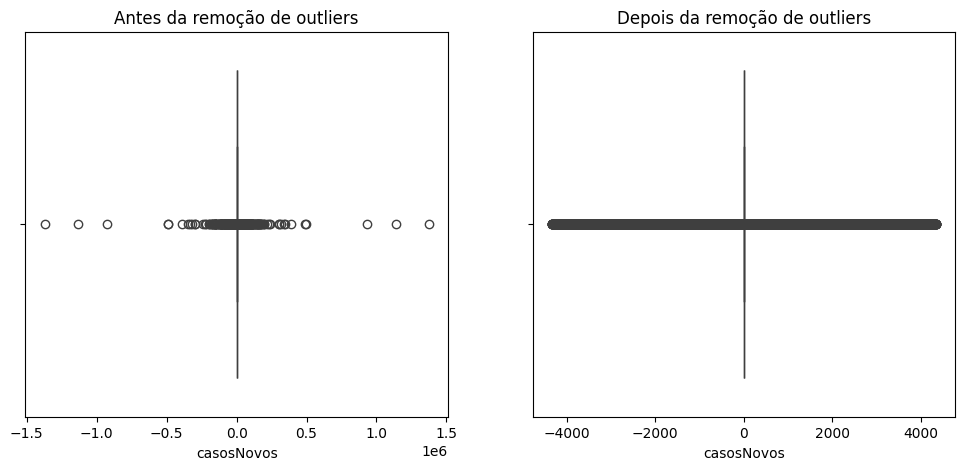

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Antes da remoção de outliers")
sns.boxplot(data=df, x="casosNovos")

plt.subplot(1,2,2)
plt.title("Depois da remoção de outliers")
sns.boxplot(data=df_sem_outliers, x="casosNovos")

### Linha do tempo

In [12]:
def plot_comparacao_outliers(df1, df2, label1, label2):
  plt.figure(figsize=(12,5))
  plt.subplot(2,1,1)
  plt.title(label1)
  sns.lineplot(data=df1, y="casosNovos", x='data')
  plt.xticks([])
  plt.xlabel("")

  plt.subplot(2,1,2)
  plt.title(label2)
  sns.lineplot(data=df2, y="casosNovos", x='data')
  plt.xticks([])
  plt.xlabel("")

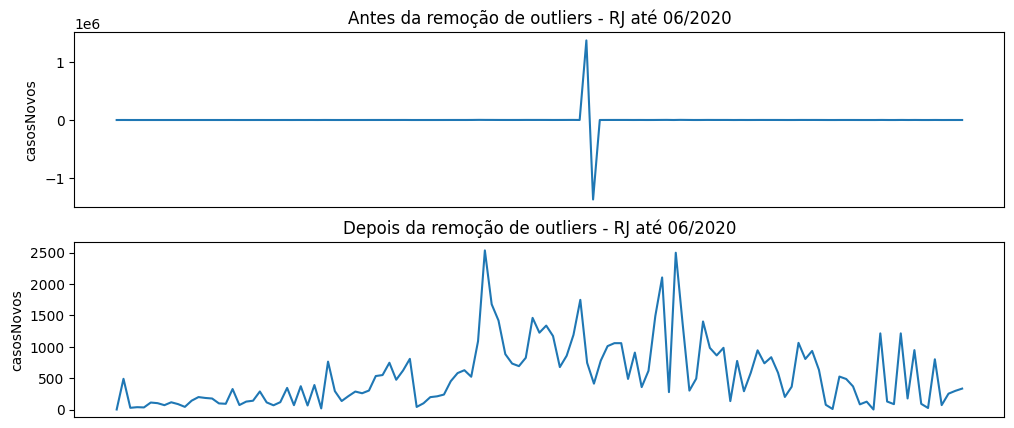

In [13]:
plot_df = df[df['municipio'] == 'Rio de Janeiro']
plot_df_sem_outliers = df_sem_outliers[df_sem_outliers['municipio'] == 'Rio de Janeiro']

plot_comparacao_outliers(plot_df, plot_df_sem_outliers, "Antes da remoção de outliers - RJ até 06/2020", "Depois da remoção de outliers - RJ até 06/2020")

### Plot outliers

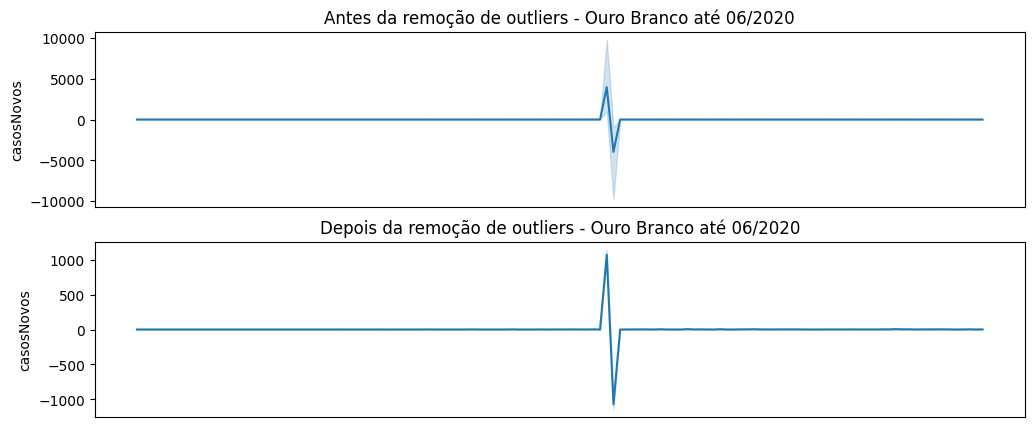

In [14]:
cidade = "São João del Rei"
cidade = "Ouro Branco"
plot_df = df[df['municipio'] == cidade]
plot_df_sem_outliers = df_sem_outliers[df_sem_outliers['municipio'] == cidade]

plot_comparacao_outliers(plot_df, plot_df_sem_outliers, f"Antes da remoção de outliers - {cidade} até 06/2020", f"Depois da remoção de outliers - {cidade} até 06/2020")

### Casos negativos

In [15]:
len(df_sem_outliers[df_sem_outliers['casosNovos'] < 0])

11267

In [16]:
contagem_de_valores_negativos = df_sem_outliers[df_sem_outliers['casosNovos'] < 0].sort_values(by='casosNovos', ascending=False).casosNovos.value_counts().reset_index()

contagem_de_valores_negativos[contagem_de_valores_negativos['count'] == 1].sort_values(by='casosNovos')

,casosNovos,count
1168,-4335,1
1196,-4331,1
1195,-4325,1
1194,-4323,1
1193,-4318,1
...,...,...
1207,-50,1
1222,-49,1
1171,-46,1
1170,-45,1


### Notas

Percebemos que continuam muitos outliers e precisamos de uma estrategia para remover mais efetivamente esses outliers.

Para isso, chegamos na conclusão que podemos utilizar uma janela deslizante calculando sua média e se o valor for muito maior que um limite, repete-se o ultimo valor.

In [17]:
import pandas as pd

def smooth_data(df, window_size=3, threshold=2):
    """
    Smooth data by replacing outliers with previous day's casosNovos.
    
    Parameters:
    - df: pandas DataFrame with columns 'date' and 'casosNovos'
    - window_size: number of days to consider in rolling window
    - threshold: number of standard deviations to use for outlier detection
    
    Returns:
    - DataFrame with smoothed values
    """
    # Make a copy to avoid modifying original data
    df_smoothed = df.copy()
    
    # Calculate rolling statistics
    rolling_mean = df['casosNovos'].rolling(window=window_size, center=True, min_periods=1).mean()
    rolling_std = df['casosNovos'].rolling(window=window_size, center=True, min_periods=1).std()
    
    # Identify outliers (values outside mean ± threshold*std)
    lower_bound = rolling_mean - threshold * rolling_std
    upper_bound = rolling_mean + threshold * rolling_std
    
    is_outlier = (df['casosNovos'] < lower_bound) | (df['casosNovos'] > upper_bound)
    
    # Replace outliers with previous day's value
    df_smoothed['casosNovos'] = df['casosNovos'].where(~is_outlier, df['casosNovos'].shift(1))
    
    # For the first row (no previous value), use the next value if available
    if is_outlier.iloc[0] and len(df) > 1:
        df_smoothed.iloc[0, df_smoothed.columns.get_loc('casosNovos')] = df['casosNovos'].iloc[1]
    
    return df_smoothed

In [18]:
import pandas as pd

window_size = 3
threshold = 2
# Make a copy to avoid modifying original data
df_smoothed = df.copy()
    
# Calculate rolling statistics
rolling_mean = df['casosNovos'].rolling(window=window_size, center=False, closed='left').mean()
rolling_std = df['casosNovos'].rolling(window=window_size, center=False, closed='left').std()

# # Identify outliers (values outside mean ± threshold*std)
lower_bound = rolling_mean - threshold * rolling_std
upper_bound = rolling_mean + threshold * rolling_std
    
is_outlier = (df['casosNovos'] < lower_bound) | (df['casosNovos'] > upper_bound)

df_smoothed['rolling_mean'] = rolling_mean
df_smoothed['rolling_std'] = rolling_std
df_smoothed['lower_bound'] = lower_bound
df_smoothed['upper_bound'] = upper_bound
df_smoothed['is_outlier'] = is_outlier

# Replace outliers with previous day's value
# df_smoothed['casosNovos'] = df['casosNovos'].where(~is_outlier, df['casosNovos'].shift(1))

for i in range(1, len(df_smoothed)):
    if is_outlier[i]:
        df_smoothed.at[i, 'casosNovos'] = df_smoothed.at[i-1, 'casosNovos']

df_smoothed[['casosNovos', 'lower_bound', 'upper_bound', 'is_outlier', 'z_score', 'rolling_mean', 'rolling_std']].iloc[418129:418138]
    
# return df_smoothed

,casosNovos,lower_bound,upper_bound,is_outlier,z_score,rolling_mean,rolling_std
418129,0,0.000000,0.000000,False,-0.000864,0.000000,0.000000
418130,0,0.000000,0.000000,True,-0.001095,0.000000,0.000000
418131,0,-1.487392,0.820726,False,-0.000864,-0.333333,0.577029
418132,0,-1.487392,0.820726,False,-0.000864,-0.333333,0.577029
418133,0,-1.487392,0.820726,False,-0.000864,-0.333333,0.577029
418134,0,0.000000,0.000000,False,-0.000864,0.000000,0.000000
418135,0,0.000000,0.000000,False,-0.000864,0.000000,0.000000
418136,0,0.000000,0.000000,False,-0.000864,0.000000,0.000000
418137,0,0.000000,0.000000,False,-0.000864,0.000000,0.000000


In [19]:
def smooth_data(df, window_size=7, threshold=2):
    """
    Smooth data by replacing outliers with previous day's casosNovos.
    Df must be indexed.
    
    Parameters:
    - df: pandas DataFrame with columns 'date' and 'casosNovos'
    - window_size: number of days to consider in rolling window
    - threshold: number of standard deviations to use for outlier detection
    
    Returns:
    - DataFrame with smoothed values
    """
    # Make a copy to avoid modifying original data
    df_smoothed = df.copy()
    
    # Calculate rolling statistics
    rolling_mean = df['casosNovos'].rolling(window=window_size, center=False, closed='left').mean()
    rolling_std = df['casosNovos'].rolling(window=window_size, center=False, closed='left').std()

    # # Identify outliers (values outside mean ± threshold*std)
    lower_bound = rolling_mean - threshold * rolling_std
    upper_bound = rolling_mean + threshold * rolling_std
    
    is_outlier = (df['casosNovos'] < lower_bound) | (df['casosNovos'] > upper_bound)

    df_smoothed['rolling_mean'] = rolling_mean
    df_smoothed['rolling_std'] = rolling_std
    df_smoothed['lower_bound'] = lower_bound
    df_smoothed['upper_bound'] = upper_bound
    df_smoothed['is_outlier'] = is_outlier
    
    for i in range(1, len(df_smoothed)):
      if is_outlier[i]:
        df_smoothed.at[i, 'casosNovos'] = df_smoothed.at[i-1, 'casosNovos']
    
    return df_smoothed

In [20]:
smoothed_df = df.sort_values(by=['municipio', 'data'])

smoothed_df = smooth_data(smoothed_df, window_size=7, threshold=1)

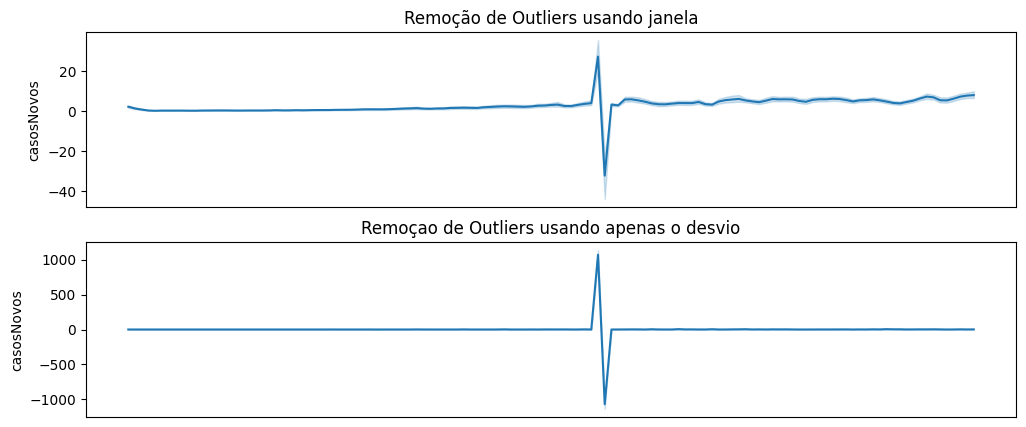

In [21]:
plot_comparacao_outliers(smoothed_df, plot_df_sem_outliers, "Remoção de Outliers usando janela", "Remoçao de Outliers usando apenas o desvio")

In [22]:
import numpy as np

# df_smoothed[['casosNovos', 'lower_bound', 'upper_bound', 'is_outlier', 'z_score', 'rolling_mean', 'rolling_std']].iloc[0:100]
# df_smoothed[['data', 'casosNovos', 'municipio', 'estado', 'nomeRegiaoSaude']].iloc[714425]
df_smoothed[df_smoothed['casosNovos'] < 0][['casosNovos', 'data', 'municipio', 'estado']]
# 714425
# 4594

,casosNovos,data,municipio,estado
58,-1,2020-05-24,Alta Floresta D'Oeste,RO
145,-4,2020-04-14,Ariquemes,RO
153,-5,2020-04-22,Ariquemes,RO
166,-1,2020-05-05,Ariquemes,RO
355,-1,2020-07-06,Cabixi,RO
...,...,...,...,...
706171,-2,2020-05-17,Uruaçu,GO
706228,-1,2020-07-13,Uruaçu,GO
706594,-1,2020-06-28,Valparaíso de Goiás,GO
707135,-1,2020-07-31,Vila Boa,GO


Estamos quase concluindo a função porém provavelmente ainda temos erros quando muda de janela e de municipio.

- Podemos filtrar os dados por municipios

- Podemos trocar a função para tratar os casos nos dados limitantes de municipios

### Casos novos em São João del Rei

In [23]:
def before_after_outliers(city, state):
  city_df = df.sort_values(by=['data'])
  city_df = city_df[(city_df['municipio'] == city) & (city_df['estado'] == state)]
  city_df = city_df.reset_index()

  smoothed_df = smooth_data(city_df, window_size=7, threshold=1)

  plot_comparacao_outliers(city_df, smoothed_df, f"{city} até 06/20 - Sem limpeza", f"{city} até 06/20 - Com limpeza")

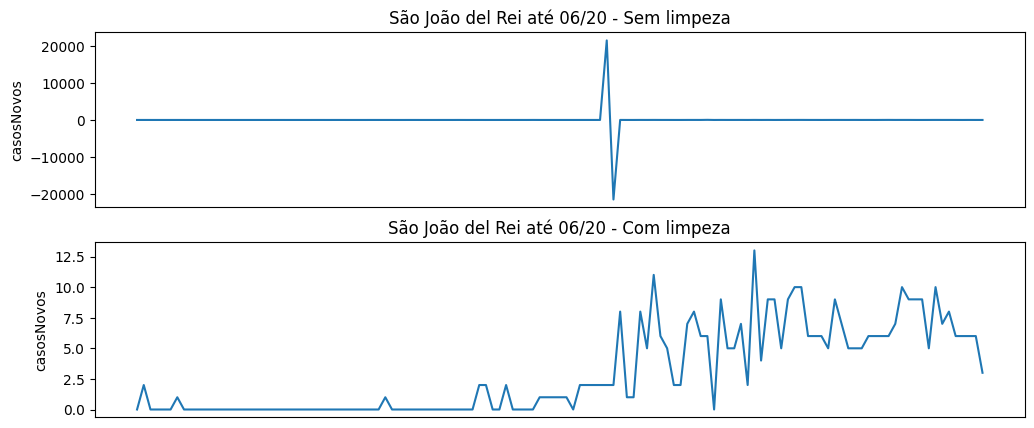

In [24]:
before_after_outliers("São João del Rei", "MG")

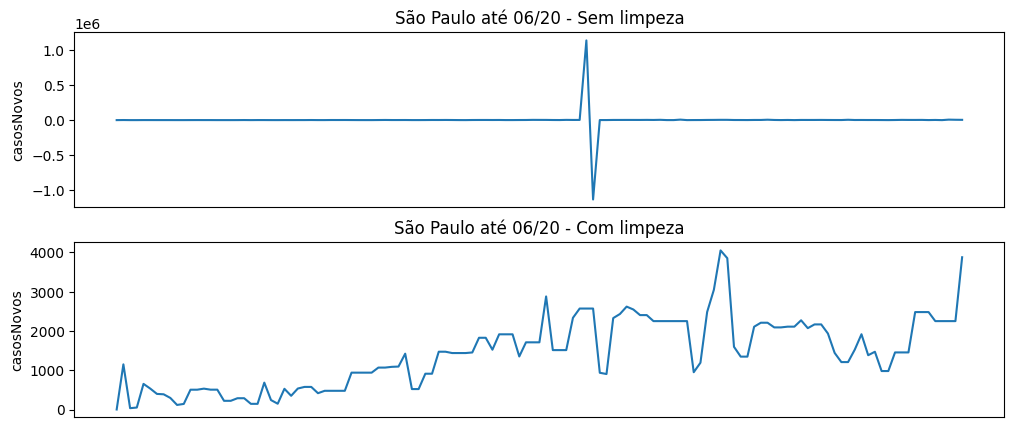

In [25]:
before_after_outliers("São Paulo", "SP")

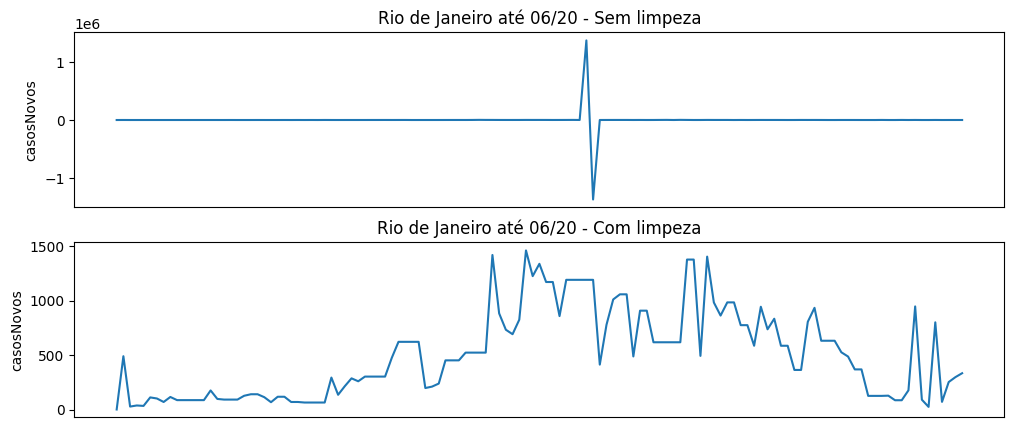

In [26]:
before_after_outliers("Rio de Janeiro", "RJ")

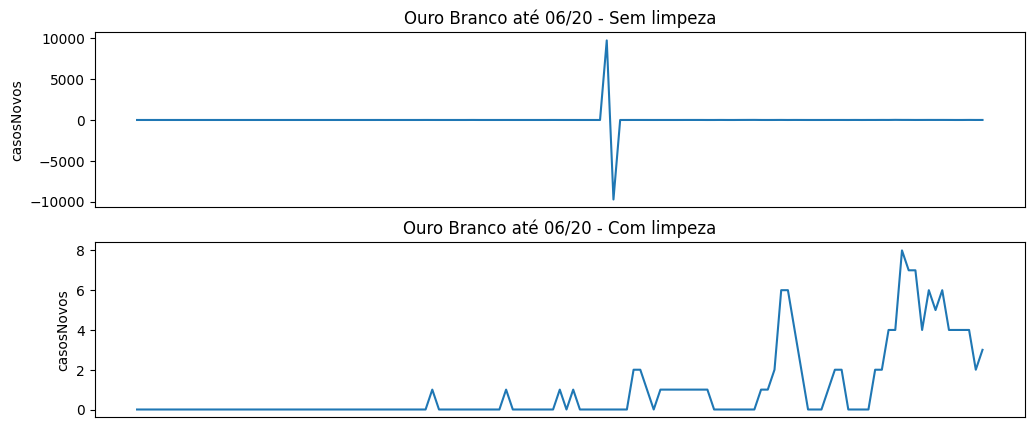

In [27]:
before_after_outliers("Ouro Branco", "MG")

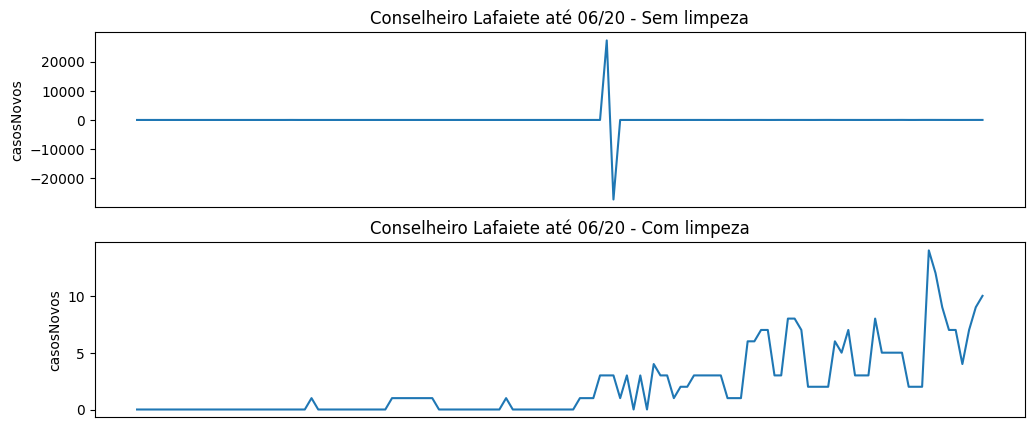

In [28]:
before_after_outliers("Conselheiro Lafaiete", "MG")

### Investigar Ouro Branco

Ao observar o município de Ouro Branco percebemos que existem municípios com o mesmo nome, então precisamos usar chave composta entre município e estado.

In [29]:
ouro_branco_df = df.sort_values(by=['data'])
ouro_branco_df = ouro_branco_df[(ouro_branco_df['municipio'] == "Ouro Branco")]
ouro_branco_df = ouro_branco_df.reset_index()
# ouro_branco_df[ouro_branco_df['casosNovos'] > 2500]
ouro_branco_df.iloc[210:216]

,level_0,index,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana,z_score
210,148279,153592,Nordeste,RN,Ouro Branco,24,240850.0,24004.0,4ª REGIAO DE SAUDE - CAICO,2020-06-05,23,4812.0,1144,1139,6,6,NaN,NaN,0.0,0.261630
211,217748,223442,Nordeste,AL,Ouro Branco,27,270610.0,27009.0,9ª REGIAO DE SAUDE,2020-06-05,23,11496.0,1022,1003,13,13,NaN,NaN,0.0,0.230287
212,353130,359205,Sudeste,MG,Ouro Branco,31,314590.0,31078.0,CONGONHAS,2020-06-05,23,39500.0,9772,9758,71,71,NaN,NaN,0.0,2.247967
213,353131,359206,Sudeste,MG,Ouro Branco,31,314590.0,31078.0,CONGONHAS,2020-06-06,23,39500.0,20,-9752,0,-71,NaN,NaN,0.0,-2.248313
214,217749,223443,Nordeste,AL,Ouro Branco,27,270610.0,27009.0,9ª REGIAO DE SAUDE,2020-06-06,23,11496.0,21,-1001,0,-13,NaN,NaN,0.0,-0.231555
215,148280,153593,Nordeste,RN,Ouro Branco,24,240850.0,24004.0,4ª REGIAO DE SAUDE - CAICO,2020-06-06,23,4812.0,5,-1139,0,-6,NaN,NaN,0.0,-0.263359


# Recalcular casos acumulados

In [30]:
def recalcula_casos_acumulados(df):
  df['novos_casos_acumulados'] = df['casosNovos'].cumsum()
  return df

<Axes: >

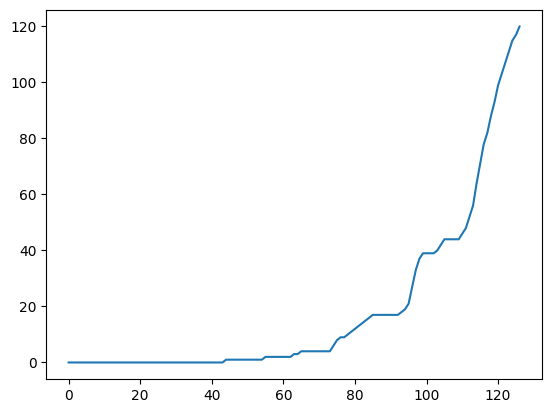

In [31]:
ouro_branco_df = df.copy()

ouro_branco_df = ouro_branco_df[(ouro_branco_df['municipio'] == "Ouro Branco") & (ouro_branco_df['estado'] == 'MG')]

ouro_branco_df = ouro_branco_df.reset_index()
ouro_branco_df = smooth_data(ouro_branco_df, window_size=7, threshold=1)

ouro_branco_df = recalcula_casos_acumulados(ouro_branco_df)
ouro_branco_df['novos_casos_acumulados'].plot()